# Churn Prediction Model

## 1. Data Loading and Initial Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('churn_data.csv')
print(f"Dataset shape: {df.shape}")
print(f'Dataset info:')
print(df.info())
print(f'First few rows:')
print(df.head())
print(f'Missing values:')
print(df.isnull().sum())
print(f'Churn distribution:')
print(df['Exited'].value_counts())

Dataset shape: (10002, 14)
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB
None
First few rows:
   RowNumber  CustomerId   Surn

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Exploratory Data Analysis (EDA) & Feature Engineering

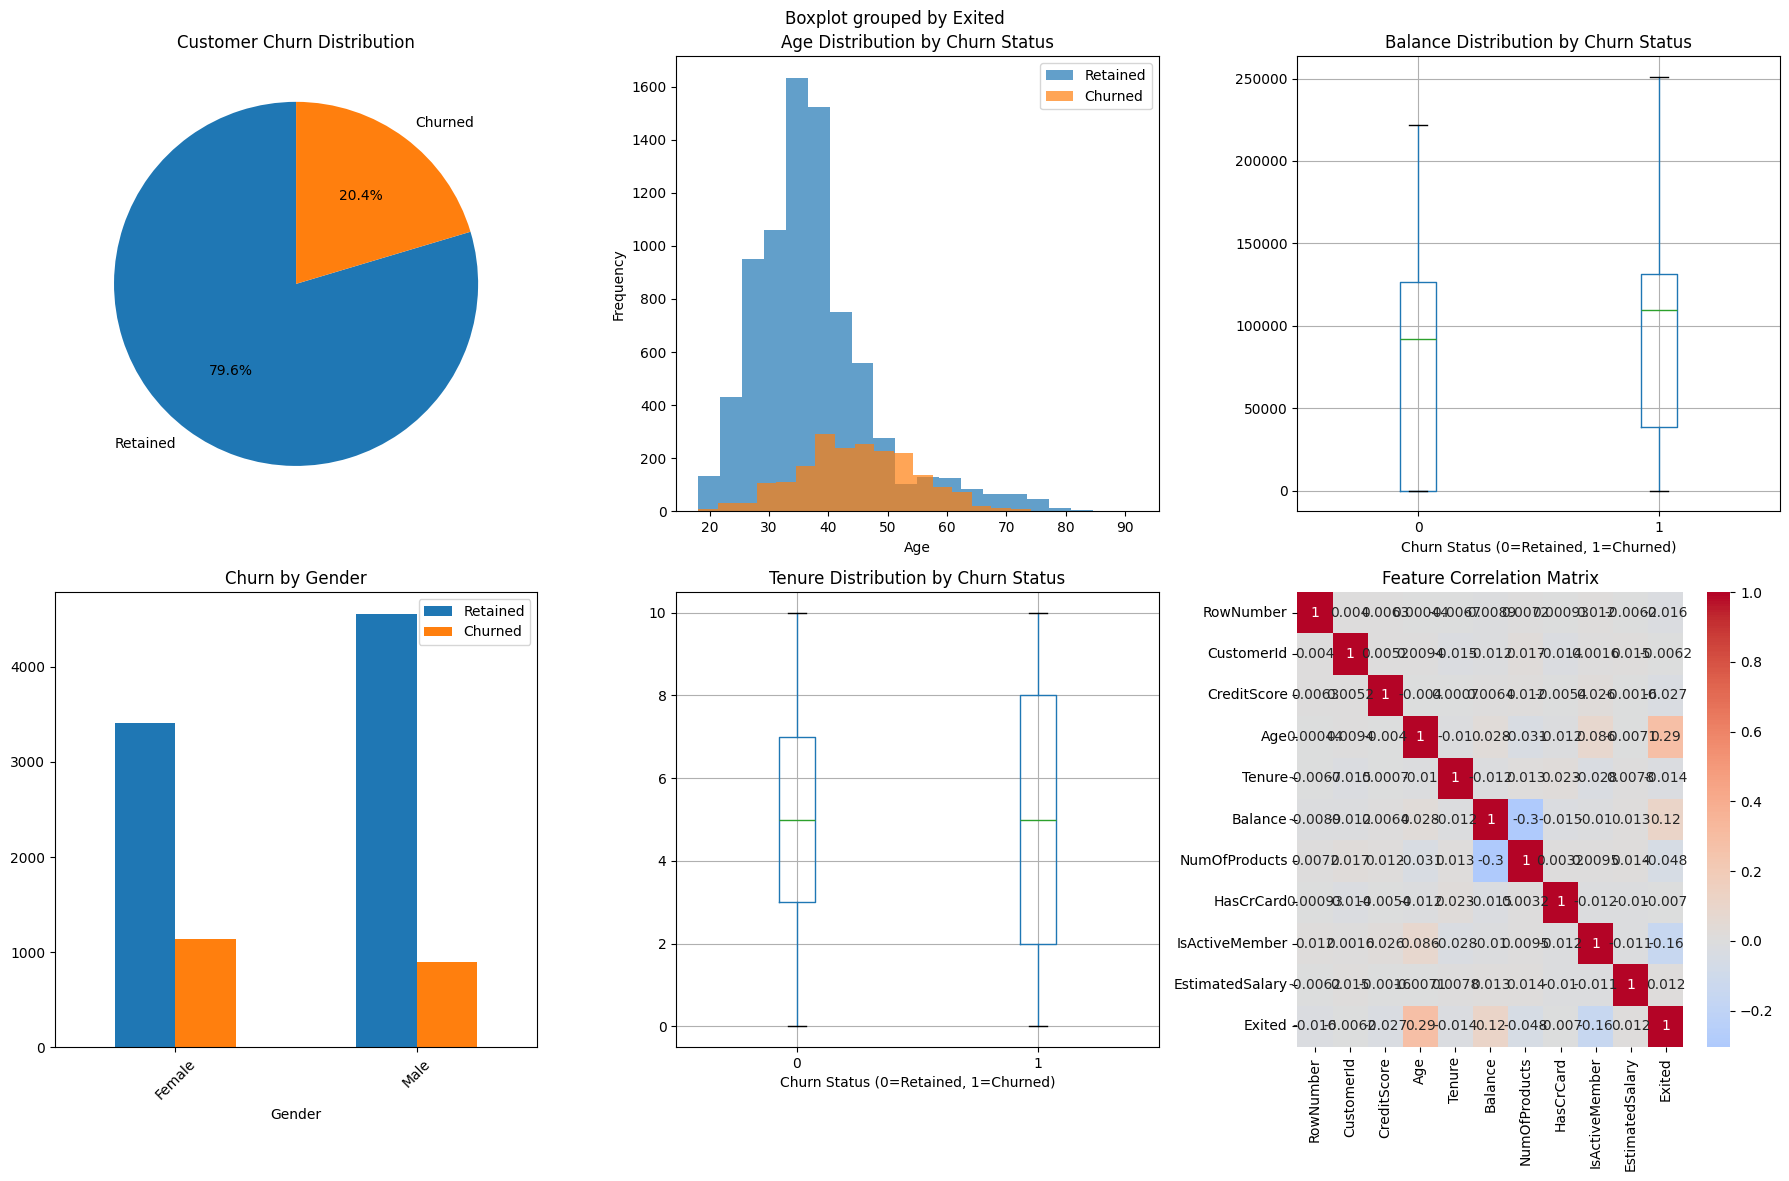

=== KEY INSIGHTS ===
Churn rate: 20.38%
Average age of churned customers: 44.8
Average age of retained customers: 37.4
Average balance of churned customers: $91100.67
Average balance of retained customers: $72752.50


In [2]:
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Churn distribution
axes[0, 0].pie(df['Exited'].value_counts(), labels=['Retained', 'Churned'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Customer Churn Distribution')

# Age distribution by churn
for exit_status in [0, 1]:
    subset = df[df['Exited'] == exit_status]
    axes[0, 1].hist(subset['Age'], alpha=0.7, bins=20, label=f'{"Churned" if exit_status else "Retained"}')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Age Distribution by Churn Status')
axes[0, 1].legend()

# Balance distribution by churn
df.boxplot(column='Balance', by='Exited', ax=axes[0, 2])
axes[0, 2].set_title('Balance Distribution by Churn Status')
axes[0, 2].set_xlabel('Churn Status (0=Retained, 1=Churned)')

# Gender vs Churn
churn_by_gender = pd.crosstab(df['Gender'], df['Exited'])
churn_by_gender.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Churn by Gender')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].legend(['Retained', 'Churned'])
axes[1, 0].tick_params(axis='x', rotation=45)

# Tenure vs Churn
df.boxplot(column='Tenure', by='Exited', ax=axes[1, 1])
axes[1, 1].set_title('Tenure Distribution by Churn Status')
axes[1, 1].set_xlabel('Churn Status (0=Retained, 1=Churned)')

# Correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
axes[1, 2].set_title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# Print some insights
print("=== KEY INSIGHTS ===")
print(f"Churn rate: {df['Exited'].mean():.2%}")
print(f"Average age of churned customers: {df[df['Exited']==1]['Age'].mean():.1f}")
print(f"Average age of retained customers: {df[df['Exited']==0]['Age'].mean():.1f}")
print(f"Average balance of churned customers: ${df[df['Exited']==1]['Balance'].mean():.2f}")
print(f"Average balance of retained customers: ${df[df['Exited']==0]['Balance'].mean():.2f}")


## 3. Data Preprocessing

In [3]:
df_processed = df.copy()
df_processed = df_processed.drop(['RowNumber', 'Surname'], axis=1)
df_processed = df_processed.fillna(df_processed.mean(numeric_only=True))

le_gender = LabelEncoder()
df_processed['Gender'] = le_gender.fit_transform(df_processed['Gender'])

df_processed = pd.get_dummies(df_processed, columns=['Geography'], drop_first=True)

df_processed['Age_Group'] = pd.cut(df_processed['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Middle', 'Senior'])
df_processed['Age_Group'] = LabelEncoder().fit_transform(df_processed['Age_Group'])

df_processed['Balance_Category'] = pd.cut(df_processed['Balance'], bins=[0, 50000, 100000, np.inf], labels=['Low', 'Medium', 'High'])
df_processed['Balance_Category'] = LabelEncoder().fit_transform(df_processed['Balance_Category'])

df_processed['Tenure_Category'] = pd.cut(df_processed['Tenure'], bins=[0, 2, 5, 10], labels=['New', 'Medium', 'Long'])
df_processed['Tenure_Category'] = LabelEncoder().fit_transform(df_processed['Tenure_Category'])

df_processed['Salary_per_Product'] = df_processed['EstimatedSalary'] / df_processed['NumOfProducts']
df_processed['Balance_per_Tenure'] = df_processed['Balance'] / (df_processed['Tenure'] + 1)
df_processed['Is_High_Value'] = ((df_processed['Balance'] > df_processed['Balance'].median()) & (df_processed['EstimatedSalary'] > df_processed['EstimatedSalary'].median())).astype(int)
df_processed['Product_Engagement'] = (df_processed['NumOfProducts'] * df_processed['IsActiveMember'] * df_processed['HasCrCard'])

X = df_processed.drop(['CustomerId', 'Exited'], axis=1)
y = df_processed['Exited']

feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Training set size: {X_train_scaled.shape}')
print(f'Test set size: {X_test_scaled.shape}')


Training set size: (7001, 18)
Test set size: (3001, 18)


## 4. Model Building

In [4]:
models = {}

print('Training Logistic Regression...')
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr

print('Training Random Forest...')
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf

print('Training XGBoost...')
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model

print(f'Trained {len(models)} models successfully!')


Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Trained 3 models successfully!


## 5. Model Evaluation

--- Logistic Regression ---
Accuracy: 0.8217
Precision: 0.6727
Recall: 0.2422
F1-Score: 0.3562
AUC: 0.7861
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2390
           1       0.67      0.24      0.36       611

    accuracy                           0.82      3001
   macro avg       0.75      0.61      0.63      3001
weighted avg       0.80      0.82      0.79      3001



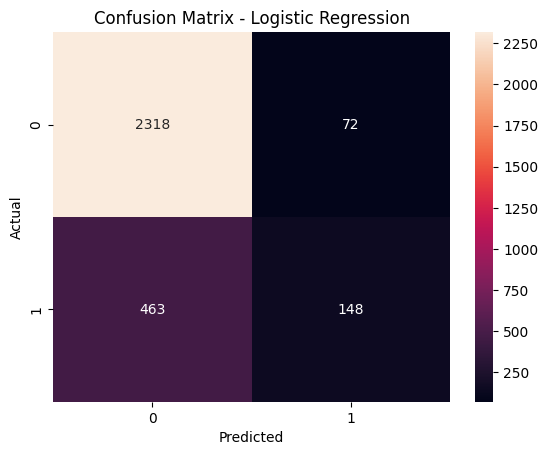

Cross-validation F1-Score: 0.3512 (+/- 0.0706)
--- Random Forest ---
Accuracy: 0.8620
Precision: 0.7613
Recall: 0.4697
F1-Score: 0.5810
AUC: 0.8621
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2390
           1       0.76      0.47      0.58       611

    accuracy                           0.86      3001
   macro avg       0.82      0.72      0.75      3001
weighted avg       0.85      0.86      0.85      3001



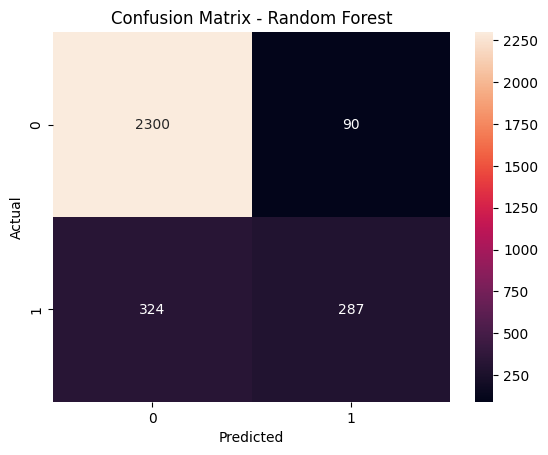

Cross-validation F1-Score: 0.5674 (+/- 0.0961)
--- XGBoost ---
Accuracy: 0.8477
Precision: 0.6689
Recall: 0.4992
F1-Score: 0.5717
AUC: 0.8428
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2390
           1       0.67      0.50      0.57       611

    accuracy                           0.85      3001
   macro avg       0.77      0.72      0.74      3001
weighted avg       0.84      0.85      0.84      3001



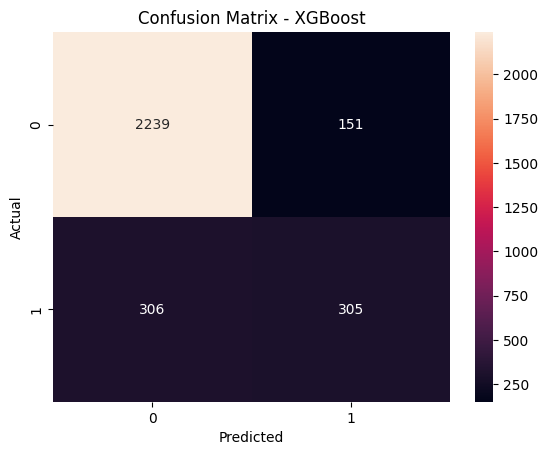

Cross-validation F1-Score: 0.5562 (+/- 0.0611)


In [5]:
results = {}

for name, model in models.items():
    print(f'--- {name} ---')
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f'Cross-validation F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')


## 6. Model Comparison

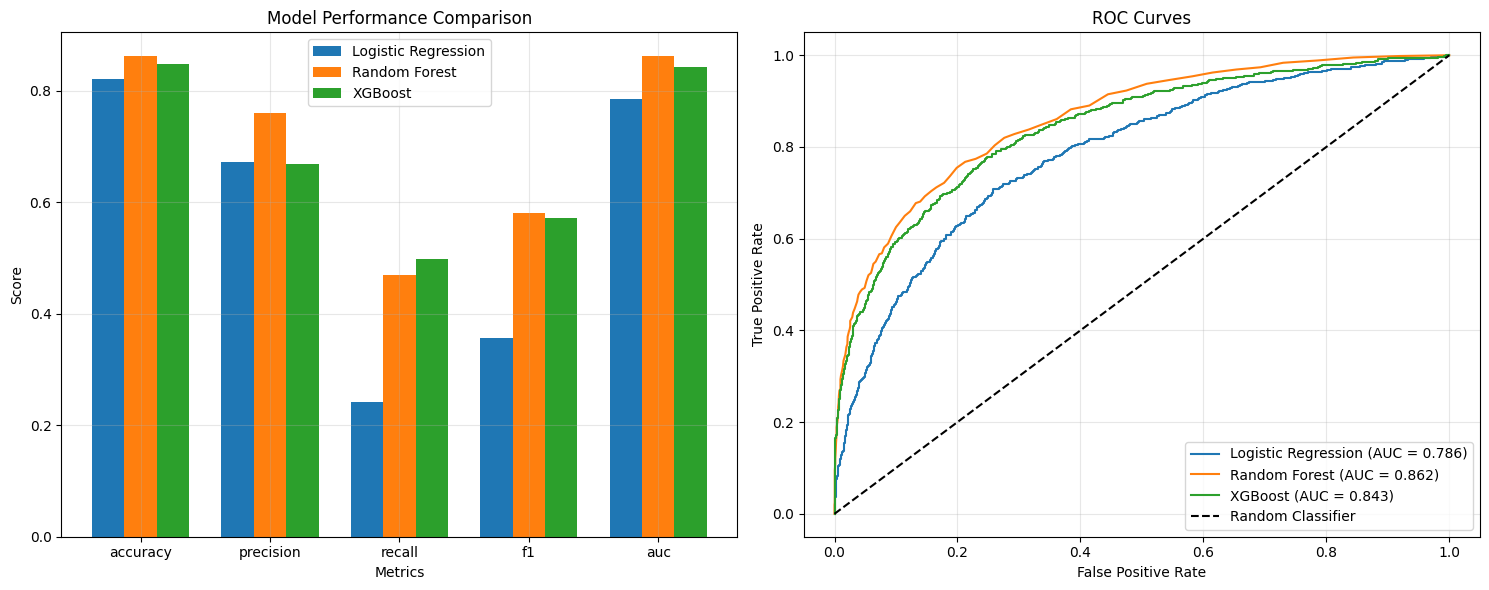

In [6]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
model_names = list(results.keys())

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

x = np.arange(len(metrics))
width = 0.25

for i, model in enumerate(model_names):
    values = [results[model][metric] for metric in metrics]
    axes[0].bar(x + i * width, values, width, label=model)

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x + width)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for name, model in models.items():
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Model Interpretability (SHAP)

Best Model: Random Forest


<Figure size 1000x600 with 0 Axes>

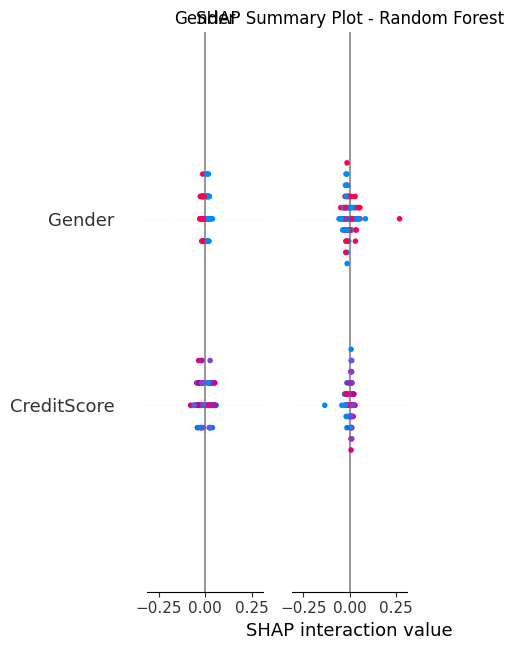

Top 10 Most Important Features:
               feature  importance
2                  Age    0.094915
5        NumOfProducts    0.043701
7       IsActiveMember    0.039250
9    Geography_Germany    0.027975
14  Salary_per_Product    0.019451
4              Balance    0.016961
1               Gender    0.014898
12    Balance_Category    0.013635
17  Product_Engagement    0.012932
0          CreditScore    0.012492


In [10]:
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model = models[best_model_name]

print(f'Best Model: {best_model_name}')

if best_model_name == 'XGBoost':
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.Explainer(best_model, X_train_scaled)

shap_values = explainer.shap_values(X_test_scaled[:100], check_additivity=False)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=feature_names, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}')
plt.tight_layout()
plt.show()

feature_importance = np.abs(shap_values).mean(axis=(0, 2))  

feature_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print('Top 10 Most Important Features:')
print(feature_imp_df.head(10))


## 8. Save Predictions

In [12]:
best_f1 = max(results.items(), key=lambda x: x[1]['f1'])
best_model_name = best_f1[0]
best_model = models[best_model_name]

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

def categorize_probability(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

churn_prob_category = [categorize_probability(p) for p in y_pred_proba]

predictions_df = pd.DataFrame({
    'CustomerId': X_test.index,
    'Actual_Churn': y_test,
    'Predicted_Churn': y_pred,
    'Churn_Probability': y_pred_proba,
    'Churn_Probability_Category': churn_prob_category
})

predictions_df.to_csv('churn_predictions.csv', index=False)
print('Predictions saved to churn_predictions.csv')
print(predictions_df.head())


Predictions saved to churn_predictions.csv
      CustomerId  Actual_Churn  Predicted_Churn  Churn_Probability  \
4966        4966             0                0               0.04   
8658        8658             0                0               0.39   
2637        2637             0                0               0.09   
517          517             0                0               0.29   
9936        9936             0                0               0.28   

     Churn_Probability_Category  
4966                        Low  
8658                     Medium  
2637                        Low  
517                         Low  
9936                        Low  
